In [5]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

print(sys.path[-1])  
import os
print(os.getcwd())

C:\PythonProject\RAG_COMMANDER\src
c:\PythonProject\RAG_COMMANDER\src\agents\main


In [6]:
%%writefile main_agent.py
from langchain_openai import ChatOpenAI
from langgraph.graph.state import Command, Literal
from agents.state.start_state import StartConfirmation, StartInput
from agents.state.main_state import MainState
from utils.llm import LLMProfile
from utils.util import get_today_str
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langgraph.graph import StateGraph, START, END
from prompts import PromptManager, PromptType
from agents.analysis.analysis_graph import analysis_graph
from agents.jung_min_jae.jung_min_jae_agent import report_graph
from copy import deepcopy

start_llm = LLMProfile.chat_bot_llm()
messages_key = MainState.KEY.messages
start_input_key = MainState.KEY.start_input
analysis_outputs_key = MainState.KEY.analysis_outputs
status_key = MainState.KEY.status


def start_confirmation(
    state: MainState,
) -> Command[Literal["start", "__end__"]]:

    parser_llm = start_llm.with_structured_output(StartConfirmation)
    messages_str = get_buffer_string(messages=state[messages_key])

    prompt = PromptManager(PromptType.MAIN_START_CONFIRMATION).get_prompt(
        messages=messages_str
    )
    response: StartConfirmation = parser_llm.invoke([HumanMessage(content=prompt)])

    if response.confirm == False:
        return Command(
            goto=END, update={messages_key: [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="start",
            update={messages_key: [AIMessage(content=response.verification)]},
        )


def start(state: MainState) -> MainState:
    parser_model = start_llm.with_structured_output(StartInput)
    prompt = PromptManager(PromptType.MAIN_START).get_prompt(
        messages=get_buffer_string(state[messages_key]), date=get_today_str()
    )
    response: StartInput = parser_model.invoke([HumanMessage(content=prompt)])
    return {start_input_key: response.model_dump(), status_key: "ANALYSIS"}


def analysis_graph_node(state: MainState) -> MainState:
    result = analysis_graph.invoke({"start_input": deepcopy(state[start_input_key])})
    return {
        "analysis_outputs": result.get("analysis_outputs", {}),
        status_key: "JUNG_MIN_JAE"
    }


def jung_min_jae_graph(state: MainState) -> MainState:
    result = report_graph.invoke({"start_input": deepcopy(state[start_input_key]),
                                  "analysis_outputs": deepcopy(state[analysis_outputs_key]),
                                  "segment":1
                                  })
    return {
        "final_report": result["final_report"],
        status_key:"RENDERING"
    }


graph_builder = StateGraph(MainState)

start_confirmation_key = "start_confirmation"
start_key = "start"
analysis_graph_key = "analysis_graph"
jung_min_jae_key = "jung_min_jae_graph"

graph_builder.add_node(start_confirmation_key, start_confirmation)
graph_builder.add_node(start_key, start)
graph_builder.add_node(analysis_graph_key, analysis_graph_node)
graph_builder.add_node(jung_min_jae_key, jung_min_jae_graph)

graph_builder.add_edge(START, start_confirmation_key)
graph_builder.add_edge(start_key, analysis_graph_key)
graph_builder.add_edge(analysis_graph_key, jung_min_jae_key)
graph_builder.add_edge(analysis_graph_key, END)


Overwriting main_agent.py


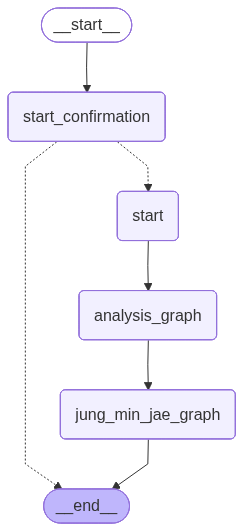

In [7]:
from main_agent import graph_builder
graph = graph_builder.compile()
graph

In [8]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState
messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = graph.invoke(
    {
        messages_key : [HumanMessage(content = "경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ")]
    },
    config = thread
)

format_message(result[messages_key])

ValueError: Invalid format string

In [ ]:
result

In [ ]:
print(result['final_report'])